# Makemore

Noted, Coded, and Created by Han Summer 2024. Part of The 20th Summer Project

------------
### Makemore

Making more things from the data given to the model.

Under the hood, **makemore is character level language model**, it means treating every single line example of data from the training set as a sequence of individual characters.

Character level language model, simpelnya cuman prediksi huruf yang selanjutnya berdasarkan sequence huruf yang udah ada (before it)

----
## This page is a the finished implementation of makemore model including Statistic Bigram, NN Bigram with Batch Norm

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

### Read Dataset (Run This first)

In [7]:
# Open the dataset (List of names) as a python list of strings which is words in this case
# Can be changed to any text file with words separated by newlines
word= open('names.txt', 'r').read().splitlines()

In [8]:
N=torch.zeros((27,27),dtype=torch.int32)

#Make lookup table for character to index
chars=sorted(list(set(''.join(word)))) #Concat all the word in the dataset to 1 string, make it set which not allowing duplicate and sorted from a to z
#the index will start from 1 since index 0 will be used for start/end token
stoi={s:i+1 for i,s in enumerate(chars)} #Make dictionary of character to index {'a': 1, 'b': 2, 'c': 3, 'd': 4, and so on}
#Add start token and end token to the dictionary as a '.' and located in index 0
stoi['.']=0
#Inverse the matrix
itos={v:k for k,v in stoi.items()} 

### Bigram

In [28]:
def Bigram(word,namecount):

    for w in word:
        #Add start token and end token
        chs=['.']+list(w)+['.']
        for ch1, ch2 in zip(chs, chs[1:]): #Iterate with 2 characters at a time
            #Zip bakal stop ketika salah satu elemen habis, seperti chs[1:] habis duluan dibanding w
            ix1=stoi[ch1]
            ix2=stoi[ch2]
            #Counting up the occurence of the bigram
            N[ix1, ix2]+=1
    # g = torch.Generator().manual_seed(2147483647)
    
    
    P=(N+1).float() #Smoothing the model
    P=P/P.sum(1, keepdim=True)
    #for loop for how many names will be generated
    for i in range (namecount):
        out=[]
        ix=0
        while True:
            p=P[ix]
            #Generate the sample based on the probability in the row
            ix=torch.multinomial(p, num_samples=1, replacement=True).item()
            out.append(itos[ix])
            if ix==0: #This is when the char is '.' aka the end
                break
        print(''.join(out))


In [29]:
Bigram(word,10) #Generate 10 names

amciasanelarenthahin.
lirarinze.
fabe.
aimahinn.
bionielana.
n.
a.
malartalyon.
ziton.
mphelyadorudoarueilahkieestondriantolaliye.


### Bigram Neural Net

In [30]:
def NNBigram(epoch,learning_rate):
    
    #Create the training set of bigrams(x) and the target set of bigrams(y)
    xs, ys = [], []

    for w in word: #Iterate through all the bigrams
        #Add start token and end token
        chs=['.']+list(w)+['.']
        for ch1, ch2 in zip(chs, chs[1:]): #Iterate with 2 characters at a time
            #Zip bakal stop ketika salah satu elemen habis, seperti chs[1:] habis duluan dibanding w
            ix1=stoi[ch1]
            ix2=stoi[ch2]
            #Store the index value to the list
            xs.append(ix1)
            ys.append(ix2)
            
    #Convert to tensor (better to use lowercase "tensor" not "Tensor" since Tensor automatically assign the dtype to float32)
    xs=torch.tensor(xs)
    ys=torch.tensor(ys)    
    num = xs.nelement() #Number of element in the tensor
    
    # randomly initialize 27 neurons' weights. each neuron receives 27 inputs
    # g = torch.Generator().manual_seed(2147483647)
    W = torch.randn((27, 27), requires_grad=True) #requires_grad=True to make the weight can be updated by the optimizer
    
    #Model Training, gradient descent
    for i in range(epoch):
        #Forward pass
        xenc = F.one_hot(xs, num_classes=27).float() 
        logits = xenc @ W 
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims=True)
        loss=-probs[torch.arange(num), ys].log().mean()
        
        #Backward pass
        W.grad=None #Reset the gradient to zero
        loss.backward() #Calculate the gradient, torch is like micrograd, it tracks the computation graph
        
        #Update weight
        W.data += -learning_rate * W.grad
        if i % 10 == 0:
            print(f'Iter {i}, Loss {loss.item()}')
            
    return W


In [31]:
#Model training
W=NNBigram(100,50)

Epoch 0, Loss 3.800018787384033
Epoch 10, Loss 2.659454107284546
Epoch 20, Loss 2.5612409114837646
Epoch 30, Loss 2.5260512828826904
Epoch 40, Loss 2.5074403285980225
Epoch 50, Loss 2.4960408210754395
Epoch 60, Loss 2.4883546829223633
Epoch 70, Loss 2.482818841934204
Epoch 80, Loss 2.4786510467529297
Epoch 90, Loss 2.4754178524017334


In [32]:
# Make the neural net do the character prediction
def predict_next_char(W):
    g = torch.Generator().manual_seed(2147483647)

    for i in range(5):
        out = []
        ix = 0
        while True:
            xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
            logits = xenc @ W # predict log-counts
            counts = logits.exp() # counts, equivalent to N
            p = counts / counts.sum(1, keepdims=True) # probabilities for next character
            # ----------
            #Generate the sample based on the probability in the row
            ix = torch.multinomial(p, num_samples=1, replacement=True).item()
            out.append(itos[ix])
            if ix == 0:
                break
        print(''.join(out))

In [33]:
predict_next_char(W)

s.
ly.
washja.
jan.
tlilytlo.


### Neural Network with Batch Norm (Dataset split + GPU Support)

Predict next char based on 3 characters before, and with batch normalization

In [9]:
block_size=3 #How many character used for prediction

In [10]:
def build_dataset(words):
    #Context size: berapa karakter sebelum yang dipake buat predict selanjutnya
    X, Y= [], []
    for w in words:
        # print(w)
        context=[0]*block_size #Padded context of 0 tokens -> [0]* 3 = [0,0,0] -> . . .
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print (''.join(itos[i] for i in context), '-->', itos[ix])
            context=context[1:]+[ix] #rolling window of the context, remove char in first idx and add new char in last idx
    #Convert to tensor
    X= torch.tensor(X)
    Y= torch.tensor(Y)
    
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X,Y

In [11]:
#Dataset split
import random
random.seed(42)
random.shuffle(word)

In [12]:
n1= int(len(word)*0.8) #80% of the dataset
n2= int(len(word)*0.9) #90% of the dataset

X, Y= build_dataset(word)
Xtr,Ytr= build_dataset(word[:n1]) #Train
Xdev,Ydev= build_dataset(word[n1:n2]) #Validation -> 10% of the data (between 80% and 90% ; between Train and Test)
Xte,Yte= build_dataset(word[n2:]) #Test -> 10% of the data

torch.Size([228146, 3]) torch.int64 torch.Size([228146]) torch.int64
torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [13]:
#Move all to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Xtr,Ytr,Xdev,Ydev,Xte,Yte = Xtr.to(device),Ytr.to(device),Xdev.to(device),Ydev.to(device),Xte.to(device),Yte.to(device)

In [85]:
lossi = []

def trainBNest(max_steps = 200000, batch_size = 32,momentum=0.001, n_embd=10, n_hidden=200):
    
    vocab_size = len(itos)
    C  = torch.randn((vocab_size, n_embd))
    W1 = torch.randn((n_embd * block_size, n_hidden))*(5/3)/((n_embd * block_size)**0.5) #kaiming he normal init configuration
    b1 = torch.randn(n_hidden)*0.01
    W2 = torch.randn((n_hidden, vocab_size))*0.01
    b2 = torch.randn(vocab_size)*0 

    #BN parameters (Gain γ & Bias β) -> Scale and Shift
    bngain=torch.ones((1,n_hidden))
    bnbias=torch.zeros((1,n_hidden))
    #Adding variable to estimate the mean and std (mean=0, std=1)
    bnmean_running=torch.zeros((1,n_hidden))
    bnstd_running=torch.ones((1,n_hidden))
    
    C,W1,b1,W2,b2 = C.to(device), W1.to(device), b1.to(device), W2.to(device), b2.to(device)
    bnbias,bngain= bnbias.to(device), bngain.to(device)
    bnmean_running,bnstd_running= bnmean_running.to(device), bnstd_running.to(device)
    
    parameters = [C, W1, b1, W2, b2,bngain,bnbias]
    print('Num_params= ',sum(p.nelement() for p in parameters)) # number of parameters in total
    for p in parameters:
        p.requires_grad = True

    for i in range(max_steps):
        #Mini batch
        ix=torch.randint(0,Xtr.shape[0],(batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]
        Xb, Yb = Xb.to(device), Yb.to(device)
        
        #Forward pass
        emb = C[Xb]
        embcat=emb.view(emb.shape[0],-1) 
        hpreact = embcat @ W1 +b1 #b1 is useless anyway since will get subtracted in BN process
        
        #Batch Normalization=gain*(mean/std)+bias
        bnmeani=hpreact.mean(dim=0,keepdim=True) #current batch mean
        bnstdi=hpreact.std(dim=0,keepdim=True) #current batch std
    
        hpreact=bngain*((hpreact-bnmeani)/(bnstdi))+bnbias
        
        #Updating the running mean and std seperately to the NN training
        with torch.no_grad(): #The operation below is not used for gradient calculation
            #Updating by moving average
            bnmean_running=(1-momentum)*bnmean_running+momentum*bnmeani
            bnstd_running=(1-momentum)*bnstd_running+momentum*bnstdi
        
        h = torch.tanh(hpreact)  
        logits = h @ W2 + b2  
        loss = F.cross_entropy(logits, Yb) 
        
        #Backward pass
        for p in parameters:
            p.grad = None            
        loss.backward()
        
        #Update parameters
        lr = 0.1 if i < 100000 else 0.01
        for p in parameters:
            p.data -= lr*p.grad
        
        #Track stats
        if i % 10000 == 0:
            print(f'Step {i}, Loss {loss.item()}')
        lossi.append(loss.log10().item())
        
    return parameters, lossi, bnmean_running, bnstd_running

Train

In [86]:
parameters, lossi, bnmean_running, bnstd_running = trainBNest()
C, W1, b1, W2, b2, bngain, bnbias = parameters

Num_params=  12297
Step 0, Loss 3.273175001144409
Step 10000, Loss 2.600304126739502
Step 20000, Loss 2.262950897216797
Step 30000, Loss 2.483833074569702
Step 40000, Loss 1.9275245666503906
Step 50000, Loss 2.5291364192962646
Step 60000, Loss 2.4137370586395264
Step 70000, Loss 1.85837721824646
Step 80000, Loss 2.5302340984344482
Step 90000, Loss 2.2093753814697266
Step 100000, Loss 2.297924757003784
Step 110000, Loss 1.9407331943511963
Step 120000, Loss 2.3918251991271973
Step 130000, Loss 2.6181344985961914
Step 140000, Loss 2.023646354675293
Step 150000, Loss 2.1068196296691895
Step 160000, Loss 1.764400839805603
Step 170000, Loss 1.9678499698638916
Step 180000, Loss 2.1252236366271973
Step 190000, Loss 2.1495461463928223


In [92]:
@torch.no_grad() # this decorator disables gradient tracking to the function below or use '''with torch.no_grad()''': to disable gradient tracking
def split_lossBNest(split, parameters):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  # parameters=parameters.to(device)
  C,W1,b1,W2,b2,bngain,bnbias = parameters
  C,W1,b1,W2,b2,bngain,bnbias = C.to(device),W1.to(device),b1.to(device),W2.to(device),b2.to(device),bngain.to(device),bnbias.to(device)
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact= embcat@W1 + b1
  hpreact=bngain*((hpreact-bnmean_running)/(bnstd_running))+bnbias #Using fixed number from training set
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
  return( h , (embcat@W1 + b1))

In [93]:
split_lossBNest('train', parameters)
h, hr=split_lossBNest('val', parameters)

train 2.069105625152588
val 2.1114752292633057


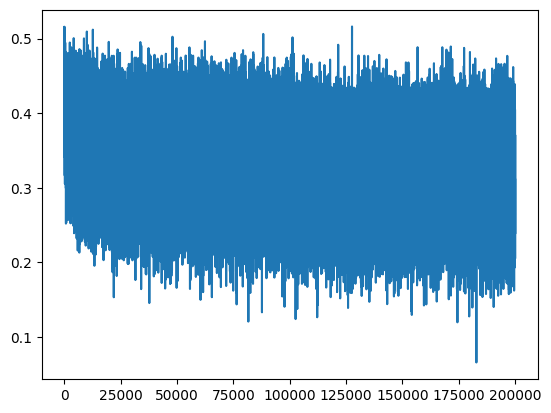

In [89]:
plt.plot(lossi)

Sample

In [94]:
# g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ... (block_size=3)
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat= emb.view(emb.shape[0], -1) # (1,block_size*d)
      hpreact = embcat @ W1 + b1
      hpreact=bngain*((hpreact-bnmean_running)/(bnstd_running))+bnbias
      h = torch.tanh(hpreact)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix] #Rolling window to update context for next character
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

zay.
makdiel.
alyn.
shyis.
alee.
emerf.
tamen.
stin.
zika.
juni.
eliyah.
bryg.
aeriell.
nie.
keidenneik.
chan.
bailley.
winne.
prisja.
torveysha.


### Generative Pre-trained Transformer (GPT) Makemore
The dataset is different from previous part

Now the dataset used is [tinyshakespeare.txt,](https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt) which can be changed in GPTMakemoretrain.py file

Hyperparameters and Import

In [107]:
import GPTMakemoreModel
from GPTMakemoreModel import GPTLanguageModel
#Hyperparameters
batch_size = 128
block_size= 256 #Context size to predict next character (context=8 berarti predict karakter ke 9 berdasarkan 8 urutan sebelumnya)
max_iters=10000
eval_interval=250 #Do evaluation every eval_interval iterations
learning_rate= 3e-4 #Self-attention ga terlalu bagus dengan learning rate yang tinggi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Use GPU (NVIDA RTX for example) if available
eval_iters=200
n_embd = 384 #Embedding dimensionsize
n_layer= 6 #Number of layers
n_head=6 #Number of heads in multi-head attention
dropout=0.2 #20% dropou

Load Data

In [102]:
file_name='tinyshakespeare.txt' # change to tinyshakespeare directory/file name
with open(file_name,'r', encoding='utf-8') as f:
    text=f.read()
    
#Vocab Ambil semua karakter unik dalam dataset
chars=sorted(list(set(text)))
vocab_size=len(chars)
# print("".join(chars))
# print(vocab_size)
#Buat tabel untuk mapping karakter ke integer dan sebaliknya
stoi={ch:i for i,ch in enumerate(chars)}
itos={i:ch for i,ch in enumerate(chars)}
#Encode (string->char to int)
encode=lambda s: [stoi[ch] for ch in s]
#Decode (int->char to string)
decode=lambda l: "".join([itos[i] for i in l])

#Train-Val split
#Misahin data menjadi train set dan validation set, supaya model bisa belajar dan diuji, kemudian kita bisa cek ga ada overfitting, ga nginget dataset doang
data=torch.tensor(encode(text), dtype=torch.long)
n= int(0.9*len(data))
train_data=data[:n]
val_data=data[n:]

#Data loader
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data # milih split train atau val
    ix = torch.randint(len(data) - block_size, (batch_size,)) # generate random index positions, generate angka random 0 sampai len(data) - block_size sebanyak batch_sizenya, buat offset di training set
    x = torch.stack([data[i:i+block_size] for i in ix]) # index ke i sampai i+block_size, ini inputnya, i itu angka yg ada di array ix
    y = torch.stack([data[i+1:i+block_size+1] for i in ix]) # targetnya adalah x yang di offset 1
    #torch.stack itu buat numpuk tensor-tensor 1D terus di tumpuk semua (stack them up at rows)
    x, y = x.to(device), y.to(device) # jika ada GPU kalkulasinya bakal kerja di GPU, jadi dipindah ke GPU
    return x, y

In [104]:
@torch.no_grad() #Kasih tau pytorch buat ga nyimpen gradient dari fungsi ini, karena ini buat evaluasi doang dan supaya lebih efisien
def estimate_loss():
    out = {}
    model.eval() # set model ke evaluation mode, karena jika layer layer tertentu bisa punya kelakuan beda saat inference(eval) dan training, contoh kek batchnorm
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # set model ke training mode
    return out


In [ ]:
model = GPTLanguageModel(vocab_size)
m = model.to(device) # jika ada GPU kalkulasinya bakal kerja di GPU, jadi dipindah ke GPU

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# save the model
model_name='model.pth'#Change to desired name
torch.save(model.state_dict(), model_name) 

Sample from GPT Model

In [109]:
model_name='modelTinyShakeSpeare.pth'

In [112]:
#load model
model_load=GPTLanguageModel(vocab_size)
model_load.load_state_dict(torch.load(model_name))
m=model_load.to(device)

In [113]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device) #Start index
#  [0] itu First dimension/firstbatch for predicition -> m.generate(context, max_new_tokens=500)[0].tolist()
print(decode(m.generate(context, max_new_tokens=5000)[0].tolist()))